# CIFAR-100 Dataset: Image Classification
## Nick Cantalupa and Sean Duffy
In this project, we will be training 4 seperate models useing different supervised machine learning techniques. These models will be classifying images using a dataset of 60,000 training images. 

## Loading dataset

In [1]:
import torch
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
ROOT_PATH = 'data'

BATCH_SIZE = 50000

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CIFAR100(root=ROOT_PATH, download=True, train=True, transform=transform)
eval_dataset = CIFAR100(root=ROOT_PATH, train=False, transform=transform)

train_data_loader = DataLoader(dataset=train_dataset, num_workers=4, batch_size=BATCH_SIZE, shuffle=True)
eval_data_loader = DataLoader(dataset=eval_dataset, num_workers=4, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified


In [3]:
import json

with open('data/cifar-100-python/meta', 'rb') as file:
    meta = pickle.load(file)

with open("labels.json", 'w') as mf:
    json.dump(meta, mf)

In [4]:
label_mapper = {}
for i , label in enumerate(meta["fine_label_names"]):
    label_mapper[i] = label
label_mapper

{0: 'apple',
 1: 'aquarium_fish',
 2: 'baby',
 3: 'bear',
 4: 'beaver',
 5: 'bed',
 6: 'bee',
 7: 'beetle',
 8: 'bicycle',
 9: 'bottle',
 10: 'bowl',
 11: 'boy',
 12: 'bridge',
 13: 'bus',
 14: 'butterfly',
 15: 'camel',
 16: 'can',
 17: 'castle',
 18: 'caterpillar',
 19: 'cattle',
 20: 'chair',
 21: 'chimpanzee',
 22: 'clock',
 23: 'cloud',
 24: 'cockroach',
 25: 'couch',
 26: 'crab',
 27: 'crocodile',
 28: 'cup',
 29: 'dinosaur',
 30: 'dolphin',
 31: 'elephant',
 32: 'flatfish',
 33: 'forest',
 34: 'fox',
 35: 'girl',
 36: 'hamster',
 37: 'house',
 38: 'kangaroo',
 39: 'keyboard',
 40: 'lamp',
 41: 'lawn_mower',
 42: 'leopard',
 43: 'lion',
 44: 'lizard',
 45: 'lobster',
 46: 'man',
 47: 'maple_tree',
 48: 'motorcycle',
 49: 'mountain',
 50: 'mouse',
 51: 'mushroom',
 52: 'oak_tree',
 53: 'orange',
 54: 'orchid',
 55: 'otter',
 56: 'palm_tree',
 57: 'pear',
 58: 'pickup_truck',
 59: 'pine_tree',
 60: 'plain',
 61: 'plate',
 62: 'poppy',
 63: 'porcupine',
 64: 'possum',
 65: 'rabbit',

In [5]:
for train_data, train_labels in train_data_loader:
    print(train_data.shape)
    print(train_labels.shape)
    break

for eval_data, eval_labels in eval_data_loader:
    print(eval_data.shape)
    print(eval_labels.shape)
    break

torch.Size([50000, 3, 32, 32])
torch.Size([50000])
torch.Size([10000, 3, 32, 32])
torch.Size([10000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


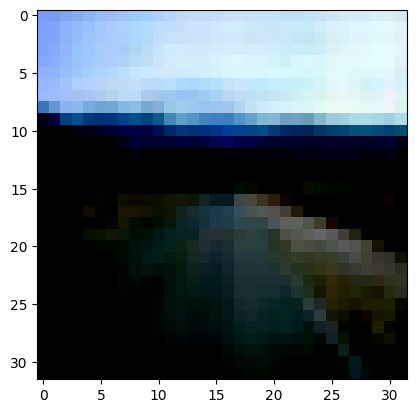

road


In [6]:
i = 3792
img = train_data[i, :].permute(1,2,0)
plt.imshow(img)
plt.show()
print(label_mapper[int(train_labels[i])])

In [7]:
train_data[0].shape

torch.Size([3, 32, 32])

## Logistic Regression

In [8]:
def validation_split(n, val_pct):
    n_val = int(n*val_pct)
    indexes = np.random.permutation(n)
    return indexes[:n_val], indexes[n_val:]

training_set, validation_set = validation_split(len(train_data), .80)
len(training_set)

40000

In [9]:
input_size = 3*32*32
num_classes = 100

3072

#### Neural LR

In [10]:
class LogisticRegressionTorch(torch.nn.Module):
    def __init__(self):
        super(LogisticRegressionTorch, self).__init__()
        self.linear = torch.nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, input_size)
        output = self.linear(xb)
        return output

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

0.00734

In [17]:
def loss_batch(model, loss_fn, xb, yb, opt=None, metric=None):
    preds = model(xb)
    loss = loss_fn(preds, yb)
    if (opt is not None):
        loss.backward()
        opt.step()
        opt.zero_grad()
    metric_result = None
    if metric is not None:
        metric_result = metric(preds,yb)
    return loss.item(), len(xb), metric_result

In [18]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb, in valid_dl]
        losses, nums, metrics = zip(*results)
        total = np.sum(nums)
        total_loss = np.sum(np.multiply(losses, nums))
        avg_loss = total_loss/total
        avg_metric = None 
        if metric is not None:
            tot_metric = np.sum(np.multiply(metrics, nums))
            avg_metric = tot_metric/total
    return avg_loss, total, avg_metric

In [20]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl, metric=None):
    for epoch in range(epochs):
        for xb, yb in train_dl:
            loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        if metric is None:
            print("Epoch[{}/{}], Loss: {:.4f}".format(epoch+1, epochs, val_loss))
        else:
            print("Epoch[{}/{}], Loss: {:.4f}, {}: {:.4f}".format(epoch+1, epochs, val_loss, metric.__name__, val_metric))

In [21]:
learning_rate = 0.1
model = LogisticRegressionTorch()
optimizer =torch.optim.SGD(model.parameters(), lr=learning_rate)

In [22]:
fit(10, model, torch.nn.functional.cross_entropy, optimizer, train_data_loader, eval_data_loader, accuracy)

Epoch[1/20], Loss: 4.5516, accuracy: 0.0306
Epoch[2/20], Loss: 4.4783, accuracy: 0.0423
Epoch[3/20], Loss: 4.4229, accuracy: 0.0503
Epoch[4/20], Loss: 4.3779, accuracy: 0.0561
Epoch[5/20], Loss: 4.3397, accuracy: 0.0614
Epoch[6/20], Loss: 4.3068, accuracy: 0.0648
Epoch[7/20], Loss: 4.2779, accuracy: 0.0686
Epoch[8/20], Loss: 4.2523, accuracy: 0.0724
Epoch[9/20], Loss: 4.2295, accuracy: 0.0763
Epoch[10/20], Loss: 4.2089, accuracy: 0.0793
Epoch[11/20], Loss: 4.1903, accuracy: 0.0833
Epoch[12/20], Loss: 4.1733, accuracy: 0.0861
Epoch[13/20], Loss: 4.1577, accuracy: 0.0891
Epoch[14/20], Loss: 4.1433, accuracy: 0.0911
Epoch[15/20], Loss: 4.1300, accuracy: 0.0927
Epoch[16/20], Loss: 4.1176, accuracy: 0.0946
Epoch[17/20], Loss: 4.1060, accuracy: 0.0972
Epoch[18/20], Loss: 4.0952, accuracy: 0.0996
Epoch[19/20], Loss: 4.0850, accuracy: 0.1015
Epoch[20/20], Loss: 4.0754, accuracy: 0.1026


#### Flattened Logistic Regression

In [36]:
flattened_data = []
for i in range(len(train_data)):
    if (i%1000 == 0):
        print(round((i/len(train_data))*100, 4),"%")
    flat = train_data[i].flatten()
    flat = flat.numpy()
    flattened_data.append(pd.Series(flat))

df = pd.DataFrame(flattened_data)

0.0 %
1.2 %
2.4 %
3.6 %
4.8 %
6.0 %
7.2 %
8.4 %
9.6 %
10.8 %
12.0 %
13.2 %
14.4 %
15.6 %
16.8 %
18.0 %
19.2 %
20.4 %
21.6 %
22.8 %
24.0 %
25.2 %
26.4 %
27.6 %
28.8 %
30.0 %
31.2 %
32.4 %
33.6 %
34.8 %
36.0 %
37.2 %
38.4 %
39.6 %
40.8 %
42.0 %
43.2 %
44.4 %
45.6 %
46.8 %
48.0 %
49.2 %
50.4 %
51.6 %
52.8 %
54.0 %
55.2 %
56.4 %
57.6 %
58.8 %
60.0 %
61.2 %
62.4 %
63.6 %
64.8 %
66.0 %
67.2 %
68.4 %
69.6 %
70.8 %
72.0 %
73.2 %
74.4 %
75.6 %
76.8 %
78.0 %
79.2 %
80.4 %
81.6 %
82.8 %
84.0 %
85.2 %
86.4 %
87.6 %
88.8 %
90.0 %
91.2 %
92.4 %
93.6 %
94.8 %
96.0 %
97.2 %
98.4 %
99.6 %


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df
y = train_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=400)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/Users/ncantalupa/opt/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Accuracy: 0.1307
